In [1]:
import os
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm
from typing import List, Tuple
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns



# Balancing Dataset

In the TrashNet dataset, the number of images per class is highly imbalanced. Dataset balancing through data augmentation is necessary to achieve balanced classes, ensuring better model training results.

In [12]:
def load_images(folder_path: str) -> List[np.ndarray]:
    """
    Load all images from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images
    
    Returns:
        List[str]: List of image file paths
    """
    images = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            img_path = os.path.join(folder_path, filename)
            images.append(img_path)
    return images

In [13]:
def apply_augmentations(images: List[str], 
                        target_count: int, 
                        transforms: List[A.Compose]) -> List[str]:
    """
    Apply augmentations to balance the dataset.
    
    Args:
        images (List[str]): Original image paths
        target_count (int): Desired number of images
        transforms (List[A.Compose]): Augmentation transforms to apply
    
    Returns:
        List[str]: Paths of augmented images
    """
    augmented_images = images.copy()
    
    while len(augmented_images) < target_count:
        # Randomly select an image to augment
        img_path = images[np.random.randint(len(images))]
        
        # Read the image
        img = cv2.imread(img_path)
        
        # Apply a random augmentation
        transform = transforms[np.random.randint(len(transforms))]
        augmented = transform(image=img)['image']
        
        # Save augmented image
        augmented_filename = f'augmented_{len(augmented_images)}.jpg'
        augmented_path = os.path.join(os.path.dirname(img_path), augmented_filename)
        cv2.imwrite(augmented_path, augmented)
        
        augmented_images.append(augmented_path)
    
    return augmented_images[:target_count]

In [14]:
def split_dataset(images: List[str], 
                  output_base_path: str, 
                  class_name: str, 
                  splits: Tuple[float, float, float] = (0.8, 0.1, 0.1)):
    """
    Split images into train, validation, and test sets.
    
    Args:
        images (List[str]): List of image paths
        output_base_path (str): Base path for output directories
        class_name (str): Name of the current class
        splits (Tuple[float, float, float]): Proportions for train, val, test
    """
    # Shuffle images
    random.shuffle(images)
    
    # Calculate split indices
    train_end = int(len(images) * splits[0])
    val_end = train_end + int(len(images) * splits[1])
    
    # Define split sets
    splits_sets = {
        'train': images[:train_end],
        'valid': images[train_end:val_end],
        'test': images[val_end:]
    }
    
    # Create directories and copy images
    for split_name, split_images in splits_sets.items():
        split_path = os.path.join(output_base_path, split_name, class_name)
        os.makedirs(split_path, exist_ok=True)
        
        for img_path in split_images:
            # Copy original image to new location
            shutil.copy(img_path, split_path)

In [4]:
def balance_and_split_dataset(dataset_path: str, 
                               target_range: Tuple[int, int] = (550, 600),
                               splits: Tuple[float, float, float] = (0.8, 0.1, 0.1)):
    """
    Balance the dataset and split into train, validation, and test sets.
    
    Args:
        dataset_path (str): Path to the dataset folder
        target_range (Tuple[int, int]): Desired range of images per class
        splits (Tuple[float, float, float]): Proportions for train, val, test
    """
    # Define augmentation transforms
    transforms = [
        # Horizontal Flip
        A.Compose([A.HorizontalFlip(always_apply=True)]),
        
        # Rotation, Rescale, and Shift
        A.Compose([A.ShiftScaleRotate(
            shift_limit=(0.0625, 0.0625), 
            scale_limit=(0.1, 0.1), 
            rotate_limit=(45, 45),
            p=1.0
        )]),
        
        # Gaussian Noise and Brightness
        A.Compose([A.GaussNoise(
            var_limit=(100,200),
            mean=-30,
            p=1.0
        )])
    ]
    
    # Create output directory for balanced and split dataset
    output_base_path = os.path.join(os.path.dirname(dataset_path), 'balanced_split_dataset')
    
    # Process each class
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        
        if os.path.isdir(class_path):
            # Load image paths
            images = load_images(class_path)
            current_count = len(images)
            
            # Determine if augmentation is needed
            if current_count < target_range[0]:
                print(f"Augmenting {class_folder}: {current_count} -> {target_range[0]}")
                augmented_images = apply_augmentations(
                    images, 
                    target_range[0], 
                    transforms
                )
            elif current_count > target_range[1]:
                print(f"Reducing {class_folder}: {current_count} -> {target_range[1]}")
                augmented_images = images[:target_range[1]]
            else:
                print(f"{class_folder} is within target range: {current_count}")
                augmented_images = images
            
            # Split the balanced dataset
            split_dataset(augmented_images, output_base_path, class_folder, splits)
    
    print("Dataset balancing and splitting complete!")

In [16]:
dataset_path = 'dataset'
balance_and_split_dataset(dataset_path)

Augmenting cardboard: 403 -> 550
Augmenting glass: 501 -> 550
Augmenting metal: 410 -> 550
paper is within target range: 594
Augmenting plastic: 482 -> 550
Augmenting trash: 137 -> 550
Dataset balancing and splitting complete!


## Sample Augmentation Data

In [8]:
# image augmentation flip horizontal(mirror) image 
transform_flip = A.Compose([A.HorizontalFlip(always_apply=True)])

# image augmentation rotation image 45 degree angle, rescale 10% and shift 0.062%
transform_shift = A.Compose([A.ShiftScaleRotate(shift_limit=(0.0625, 0.0625), 
                                                scale_limit=(0.1, 0.1), 
                                                rotate_limit=(45, 45),
                                                p=1.0)])

# image augmentation add gaussian noise and decrease brightness
transform_noise = A.Compose([A.GaussNoise(var_limit=(100,200),
                                         mean=-30,
                                         p=1.0)])

In [9]:
image = cv2.imread('dataset/plastic/plastic123.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed_flip = transform_flip(image=image)['image']
transformed_shift = transform_shift(image=image)['image']
transformed_noise = transform_noise(image=image)['image']

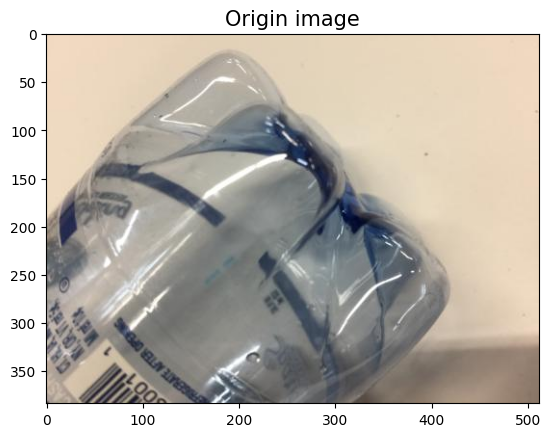

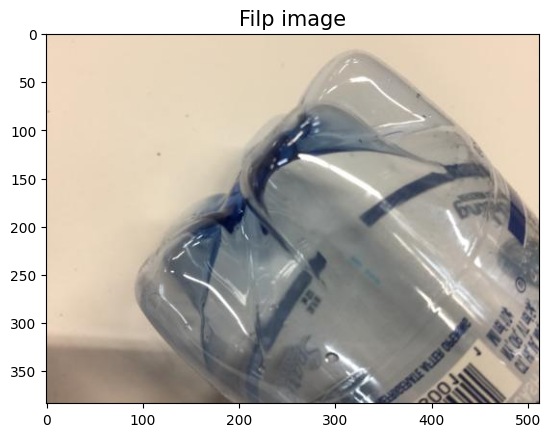

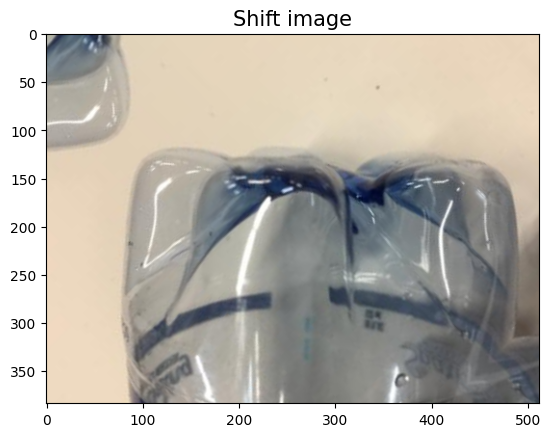

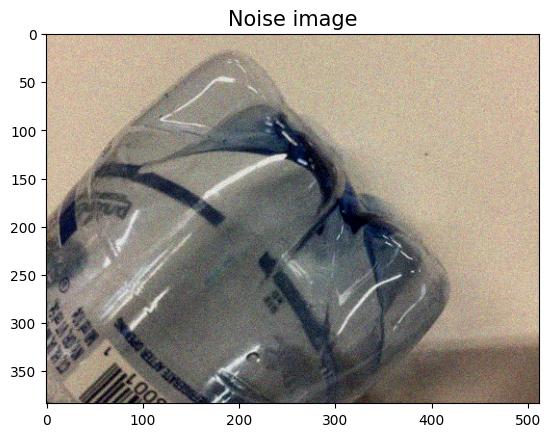

In [10]:
# Show origin and transform image
plt.imshow(image)
plt.title("Origin image", size=15)
plt.show()
plt.imshow(transformed_flip)
plt.title("Filp image", size=15)
plt.show()
plt.imshow(transformed_shift)
plt.title("Shift image", size=15)
plt.show()
plt.imshow(transformed_noise)
plt.title("Noise image", size=15)
plt.show()

# Dataset Statistics

In [4]:
def print_dataset_stats(base_path):
    """
    Print the number of images in each split and class.
    
    Args:
        base_path (str): Path to the balanced and split dataset
    """
    splits = ['train', 'valid', 'test']
    
    print("\nDataset Statistics:")
    for split in splits:
        split_path = os.path.join(base_path, split)
        print(f"\n{split.upper()} SET:")
        
        total_images = 0
        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            class_images = len(os.listdir(class_path))
            total_images += class_images
            print(f"{class_folder}: {class_images} images")
        
        print(f"Total {split} images: {total_images}")

dataset_path = 'dataset'        
print_dataset_stats(os.path.join(os.path.dirname(dataset_path), 'balanced_split_dataset'))



Dataset Statistics:

TRAIN SET:
cardboard: 440 images
glass: 440 images
metal: 440 images
paper: 475 images
plastic: 440 images
trash: 440 images
Total train images: 2675

VALID SET:
cardboard: 55 images
glass: 55 images
metal: 55 images
paper: 59 images
plastic: 55 images
trash: 55 images
Total valid images: 334

TEST SET:
cardboard: 55 images
glass: 55 images
metal: 55 images
paper: 60 images
plastic: 55 images
trash: 55 images
Total test images: 335


In [2]:
BASE_DIR_BEFORE = "dataset-raw"
BASE_DIR_AFTER = "dataset-augmented"
DATASETS = ['train', 'valid', 'test']
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
def count_images_initial(base_path):
    counts = {}
    for cls in CLASSES:
        class_path = os.path.join(base_path, cls)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            counts[cls] = num_images
        else:
            counts[cls] = 0  
    return counts

In [4]:
def count_images(base_path):
    counts = {}
    for dataset in DATASETS:
        dataset_path = os.path.join(base_path, dataset)
        class_counts = {}
        for cls in CLASSES:
            class_path = os.path.join(dataset_path, cls)
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[cls] = num_images
        counts[dataset] = class_counts
    return counts

In [13]:
def plot_class_distribution_initial(counts):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax, palette="viridis")
    ax.set_title("Initial Image Distribution in the Dataset")
    ax.set_ylabel("Number of Images")
    ax.set_xlabel("labels")
    plt.tight_layout()
    plt.show()


In [14]:
def plot_class_distribution(counts):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Final Image Distribution in the Dataset", fontsize=16)
    for idx, dataset in enumerate(DATASETS):
        sns.barplot(x=list(counts[dataset].keys()), y=list(counts[dataset].values()), ax=axes[idx], palette="viridis")
        axes[idx].set_title(f"{dataset.capitalize()} Set")
        axes[idx].set_ylabel("Number of Images")
        axes[idx].set_xlabel("labels")
    plt.tight_layout()
    plt.show()

# Data Distribution Before Preprocessing

In [15]:
image_counts_before = count_images_initial(BASE_DIR_BEFORE)

print("Image Distribution Before Preprocessing:")
for dataset, counts in image_counts_before.items():
    print(f"{dataset.capitalize()} : {counts}")

Image Distribution Before Preprocessing:
Cardboard : 403
Glass : 501
Metal : 410
Paper : 594
Plastic : 482
Trash : 137


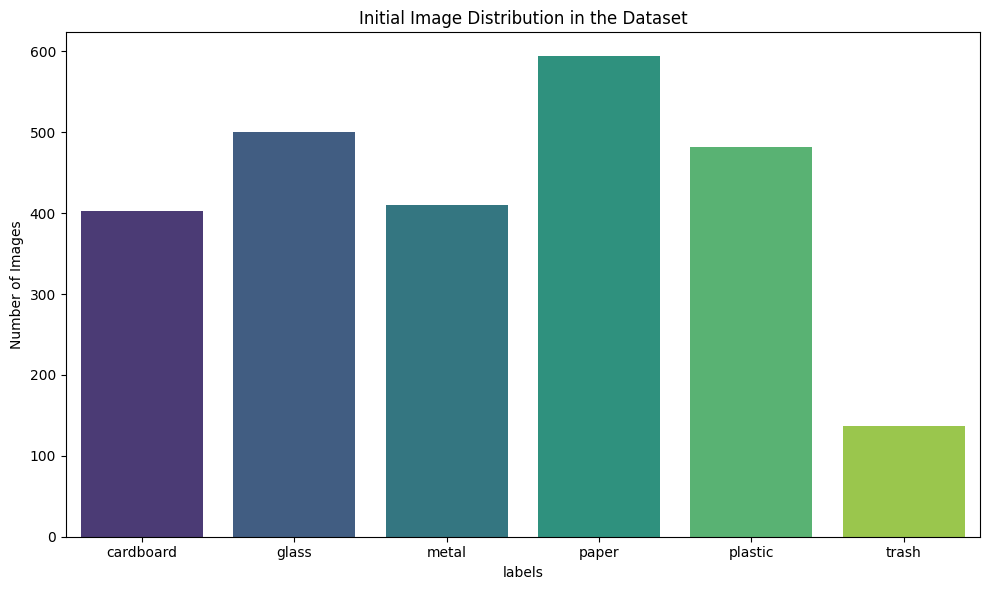

In [16]:
plot_class_distribution_initial(image_counts_before)

# Data Distribution After Preprocessing

In [17]:
image_counts_after = count_images(BASE_DIR_AFTER)

print("Image Distribution After Preprocessing:")
for dataset, counts in image_counts_after.items():
    print(f"{dataset.capitalize()} Set: {counts}")

Image Distribution After Preprocessing:
Train Set: {'cardboard': 440, 'glass': 440, 'metal': 440, 'paper': 475, 'plastic': 440, 'trash': 440}
Valid Set: {'cardboard': 55, 'glass': 55, 'metal': 55, 'paper': 59, 'plastic': 55, 'trash': 55}
Test Set: {'cardboard': 55, 'glass': 55, 'metal': 55, 'paper': 60, 'plastic': 55, 'trash': 55}


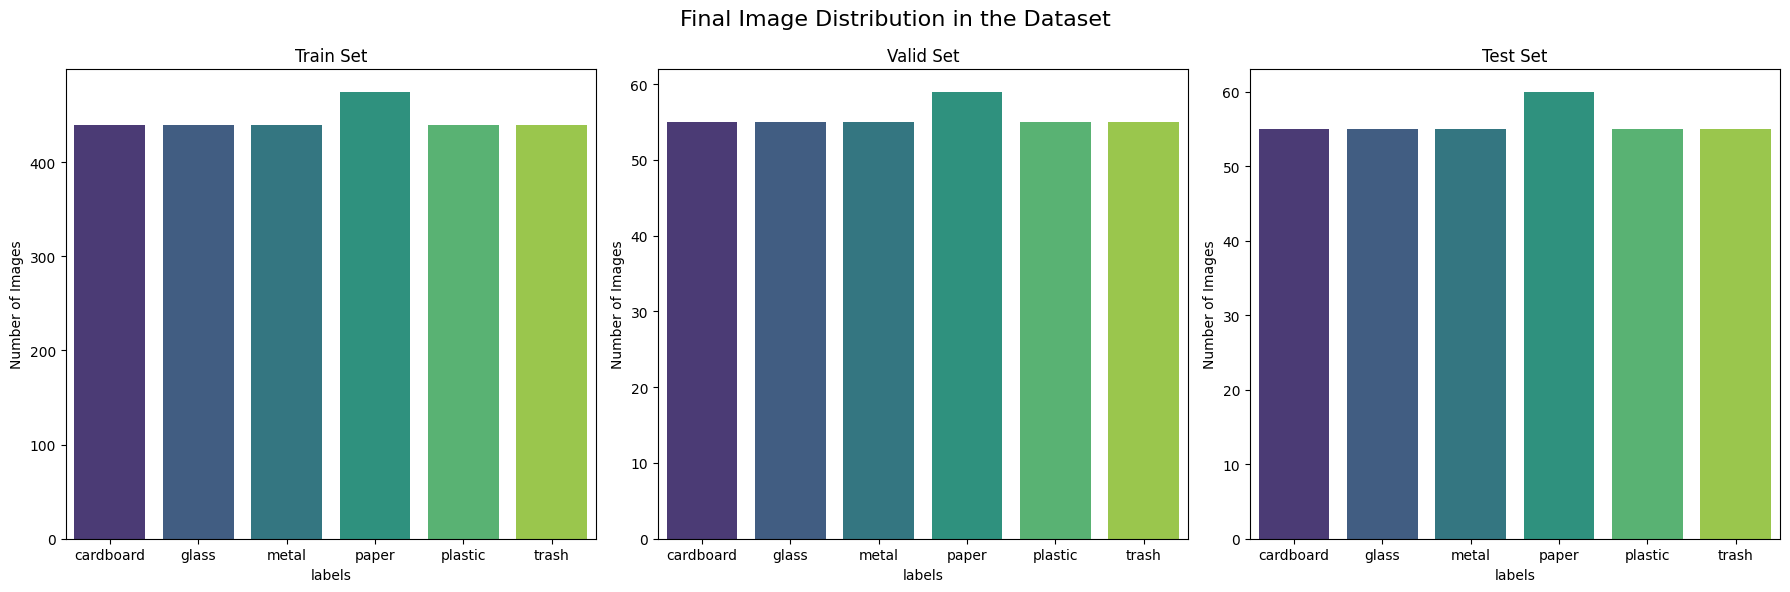

In [18]:
plot_class_distribution(image_counts_after)